# Dataset and DataLoader|

In [15]:
import os, random
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms.functional as TF
from torchvision import transforms

class HC18Dataset(Dataset):
    def __init__(self, root_dir, image_files, image_size=(256, 256)):
        self.root_dir = root_dir
        self.image_files = image_files
        self.image_size = image_size

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image and corresponding mask
        image_name = self.image_files[idx]
        mask_name = image_name.replace(".png", "_Annotation.png")
        image = Image.open(os.path.join(self.root_dir, image_name)).convert("RGB")
        mask  = Image.open(os.path.join(self.root_dir, mask_name)).convert("L")
        
        # Resize both
        image = image.resize(self.image_size)
        mask  = mask.resize(self.image_size)

        # Data augmentation: random horizontal flip
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask  = TF.hflip(mask)
        # Random small rotation
        angle = random.uniform(-15, 15)
        image = TF.rotate(image, angle)
        mask  = TF.rotate(mask, angle)

        # Convert to tensor and normalize image
        image = transforms.ToTensor()(image)
        image = transforms.Normalize([0.5]*3, [0.5]*3)(image)
        mask  = transforms.ToTensor()(mask)
        mask  = (mask > 0.5).float()   # Binarize mask
        
        return image, mask

# Prepare file lists
data_dir = "/kaggle/input/hc18-grand-challenge/training_set/"
all_images = sorted(f for f in os.listdir(data_dir) if "Annotation" not in f)
# Split into train/val (80%/20%)
train_size = int(0.8 * len(all_images))
val_size = len(all_images) - train_size
train_files, val_files = random_split(all_images, [train_size, val_size])
train_files = list(train_files); val_files = list(val_files)

# Create datasets and loaders
train_ds = HC18Dataset(data_dir, train_files, image_size=(256,256))
val_ds   = HC18Dataset(data_dir, val_files,   image_size=(256,256))
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False)


# Model (Attention U-Net) and Loss

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim

# Attention U-Net definitions (as given, unchanged)
class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(nn.Conv2d(F_g, F_int, 1), nn.BatchNorm2d(F_int))
        self.W_x = nn.Sequential(nn.Conv2d(F_l, F_int, 1), nn.BatchNorm2d(F_int))
        self.psi = nn.Sequential(nn.Conv2d(F_int, 1, 1), nn.BatchNorm2d(1), nn.Sigmoid())
        self.relu = nn.ReLU(inplace=True)
    def forward(self, g, x):
        g1 = self.W_g(g); x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels,  out_channels, 3, padding=1), nn.BatchNorm2d(out_channels), nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1), nn.BatchNorm2d(out_channels), nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.double_conv(x)

class AttentionUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)
        # Encoder
        self.downs = nn.ModuleList()
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature
        # Bottleneck
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        # Decoder
        self.ups = nn.ModuleList()
        self.att_blocks = nn.ModuleList()
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, 2, 2))
            self.att_blocks.append(AttentionBlock(F_g=feature, F_l=feature, F_int=feature//2))
            self.ups.append(DoubleConv(feature*2, feature))
        # Final conv
        self.final_conv = nn.Conv2d(features[0], out_channels, 1)

    def forward(self, x):
        skip_conns = []
        for down in self.downs:
            x = down(x)
            skip_conns.append(x)
            x = self.pool(x)
        x = self.bottleneck(x)
        skip_conns = skip_conns[::-1]
        # Decoder with attention
        for i in range(0, len(self.ups), 2):
            x = self.ups[i](x)                 # upsample
            skip = skip_conns[i//2]
            if x.shape != skip.shape:
                x = nn.functional.interpolate(x, size=skip.shape[2:])
            att = self.att_blocks[i//2](x, skip)
            x = torch.cat([att, x], dim=1)
            x = self.ups[i+1](x)
        return self.final_conv(x)

# Instantiate model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AttentionUNet().to(device)
bce_loss = nn.BCEWithLogitsLoss()
def dice_loss(inputs, targets, smooth=1e-8):
    """Computes Dice loss as 1 - Dice coefficient."""
    inputs = torch.sigmoid(inputs)
    inputs = inputs.view(inputs.size(0), -1)
    targets = targets.view(targets.size(0), -1)
    intersection = (inputs * targets).sum(1)
    dice = (2*intersection + smooth) / (inputs.sum(1) + targets.sum(1) + smooth)
    return 1 - dice.mean()

optimizer = optim.Adam(model.parameters(), lr=1e-4)


# Training Loop and Metrics

In [18]:
import torch

def dice_score(preds, targets, threshold=0.5, smooth=1e-8):
    preds = torch.sigmoid(preds) > threshold
    preds = preds.float()
    intersection = (preds * targets).sum(dim=(1,2,3))
    union = preds.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3))
    dice = (2 * intersection + smooth) / (union + smooth)
    return dice.mean()

def iou_score(preds, targets, threshold=0.5, smooth=1e-8):
    preds = torch.sigmoid(preds) > threshold
    preds = preds.float()
    intersection = (preds * targets).sum(dim=(1,2,3))
    union = (preds + targets - preds * targets).sum(dim=(1,2,3))
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean()

# Training loop
num_epochs = 10
for epoch in range(1, num_epochs+1):
    model.train()
    train_loss = 0.0; train_dice = 0.0; train_iou = 0.0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        loss = bce_loss(outputs, masks) + dice_loss(outputs, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_dice += dice_score(outputs, masks).item()
        train_iou  += iou_score(outputs, masks).item()
    train_loss /= len(train_loader)
    train_dice /= len(train_loader)
    train_iou  /= len(train_loader)
    
    # Validation metrics
    model.eval()
    val_dice = 0.0; val_iou = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            val_dice += dice_score(outputs, masks).item()
            val_iou  += iou_score(outputs, masks).item()
    val_dice /= len(val_loader)
    val_iou  /= len(val_loader)

    print(f"Epoch {epoch}: Loss={train_loss:.4f}, "
          f"Train Dice={train_dice:.4f}, Train IoU={train_iou:.4f}, "
          f"Val Dice={val_dice:.4f}, Val IoU={val_iou:.4f}")


Epoch 1: Loss=1.2214, Train Dice=0.0582, Train IoU=0.0313, Val Dice=0.1474, Val IoU=0.0814
Epoch 2: Loss=1.1451, Train Dice=0.1781, Train IoU=0.0997, Val Dice=0.2094, Val IoU=0.1189
Epoch 3: Loss=1.0825, Train Dice=0.2233, Train IoU=0.1270, Val Dice=0.2254, Val IoU=0.1282
Epoch 4: Loss=1.0319, Train Dice=0.2335, Train IoU=0.1332, Val Dice=0.2240, Val IoU=0.1273
Epoch 5: Loss=0.9892, Train Dice=0.2386, Train IoU=0.1366, Val Dice=0.2425, Val IoU=0.1392
Epoch 6: Loss=0.9518, Train Dice=0.2427, Train IoU=0.1394, Val Dice=0.2469, Val IoU=0.1422
Epoch 7: Loss=0.9194, Train Dice=0.2466, Train IoU=0.1421, Val Dice=0.2503, Val IoU=0.1443
Epoch 8: Loss=0.8919, Train Dice=0.2504, Train IoU=0.1445, Val Dice=0.2508, Val IoU=0.1452
Epoch 9: Loss=0.8691, Train Dice=0.2543, Train IoU=0.1471, Val Dice=0.2557, Val IoU=0.1485
Epoch 10: Loss=0.8524, Train Dice=0.2566, Train IoU=0.1489, Val Dice=0.2557, Val IoU=0.1485


# Visualization

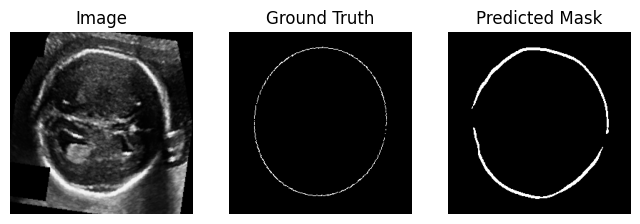

In [19]:
import matplotlib.pyplot as plt

# Example: visualize a batch from validation
model.eval()
with torch.no_grad():
    images, masks = next(iter(val_loader))
    images, masks = images.to(device), masks.to(device)
    preds = model(images)
    preds = torch.sigmoid(preds) > 0.5

# Plot the first example
img = images[0].cpu().permute(1,2,0).numpy()
true_mask = masks[0,0].cpu().numpy()
pred_mask = preds[0,0].cpu().numpy()

plt.figure(figsize=(8,4))
plt.subplot(1,3,1)
plt.imshow((img*0.5+0.5))  # unnormalize
plt.title("Image"); plt.axis("off")
plt.subplot(1,3,2)
plt.imshow(true_mask, cmap='gray')
plt.title("Ground Truth"); plt.axis("off")
plt.subplot(1,3,3)
plt.imshow(pred_mask, cmap='gray')
plt.title("Predicted Mask"); plt.axis("off")
plt.show()
